# LOAN DATASET DEFAULT

    Muhammad Fikri Abdullah Muizudin Addaulah

## Import Library

In [230]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

## Modelling
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from xgboost import plot_importance
import xgboost as xgb
from xgboost import XGBClassifier, cv
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score# evaluation metric
import shap #model interpretation


## Dataset

##### Load Dataset

In [112]:
df = pd.read_csv("Data/Loan_Default.csv")

In [113]:
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

## Data Preparation

### Treat Missing Value

    First of all define data that may have nan value

In [115]:
df['Gender'].loc[df['Gender'] == 'Sex Not Available'] = np.nan

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### Encode data

In [116]:
df = df.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

#### Impute

    Then lets handling the missing value, with this rule:

- > if the proportion of NaN values < 10% use simple imputation
- > 10% - 30% use KNN
- > more 30% Delete columns

<AxesSubplot:>

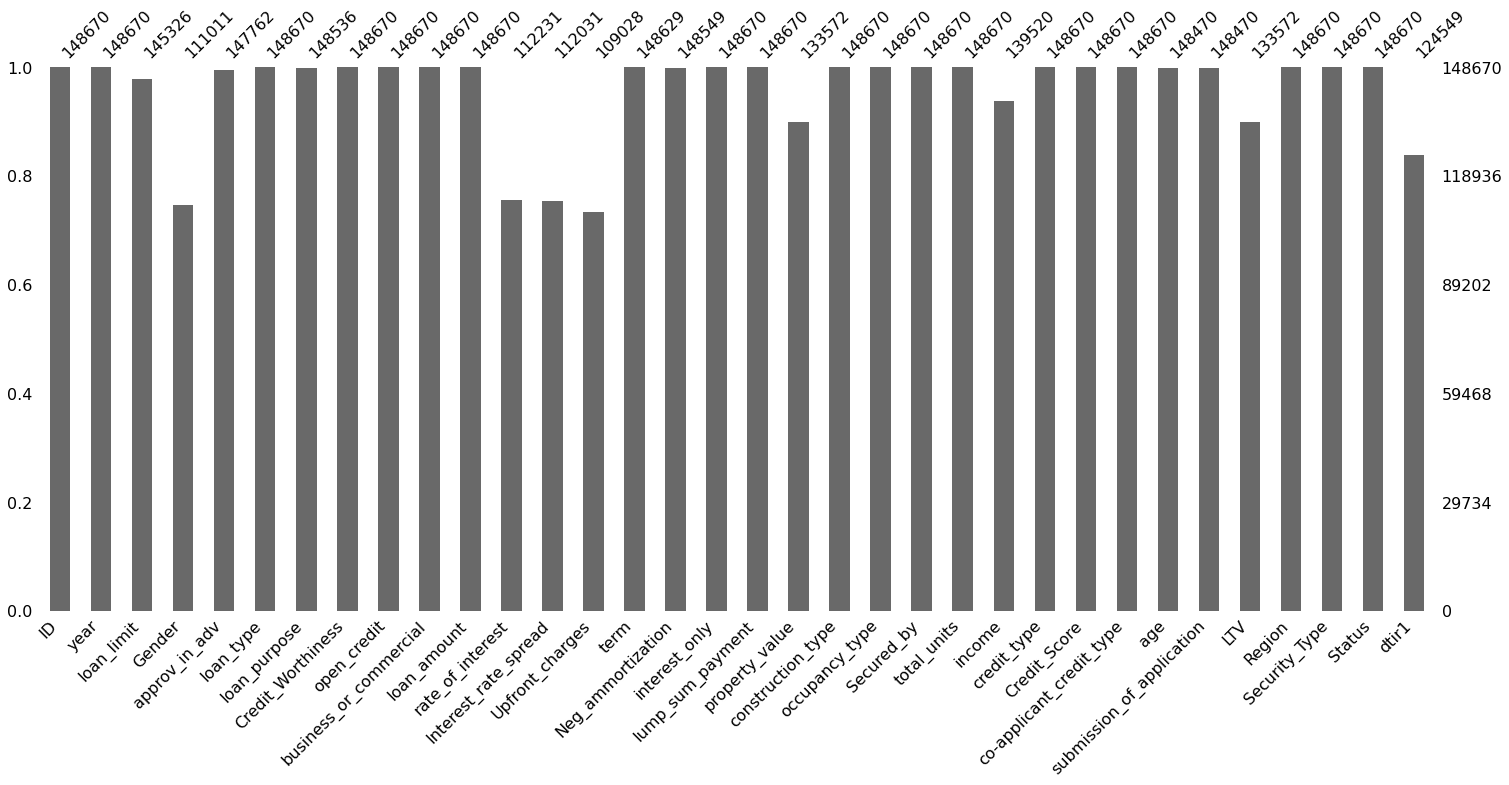

In [80]:
msno.bar(df)

In [81]:
nan = pd.DataFrame({'Proportion' : df.isna().sum()*100/len(df)})

In [84]:
nan.sort_values(by='Proportion', ascending=False)

,Proportion
Upfront_charges,26.664425
Gender,25.330598
Interest_rate_spread,24.644515
rate_of_interest,24.509989
dtir1,16.224524
LTV,10.155378
property_value,10.155378
income,6.154571
loan_limit,2.249277
approv_in_adv,0.610749


In [85]:
nan[nan['Proportion'] > 10].index

Index(['Gender', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges',
       'property_value', 'LTV', 'dtir1'],
      dtype='object')

    features with proportion 10% - 30% : ['Gender', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']

In [86]:
nan[(nan['Proportion'] < 10) & (nan['Proportion'] > 0)].index

Index(['loan_limit', 'approv_in_adv', 'loan_purpose', 'term',
       'Neg_ammortization', 'income', 'age', 'submission_of_application'],
      dtype='object')

    features with proportion >0% - 10% : ['loan_limit', 'approv_in_adv', 'loan_purpose', 'term','Neg_ammortization', 'income', 'age', 'submission_of_application']

#### KNN Imputation for proportion of nan 10%-30%

In [87]:
df_nan1030 = df[['Gender', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']].copy(deep=True)

In [88]:
df_nan1030

,Gender,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,LTV,dtir1
0,NaN,NaN,NaN,NaN,11.0,8088.0,40.0
1,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,94.0,8350.0,5087.0,50.0,7159.0,41.0
3,2.0,80.0,13155.0,NaN,65.0,6268.0,37.0
4,1.0,69.0,9392.0,0.0,75.0,7809.0,34.0
...,...,...,...,...,...,...,...
148665,NaN,28.0,8921.0,54575.0,60.0,6489.0,43.0
148666,2.0,105.0,14878.0,0.0,78.0,6705.0,10.0
148667,2.0,28.0,7166.0,10727.0,72.0,5552.0,44.0
148668,0.0,44.0,12173.0,36284.0,27.0,6404.0,24.0


In [95]:
def nan_handle(imputer, fitur, data):
    if imputer == 'knn':

        data[fitur] = df_knn
    elif imputer == 'si':

        data[fitur] = df_si

In [99]:
impute_knn = KNNImputer()
impute_knn.fit(df_nan1030)

KNNImputer()

In [98]:
df_knn = impute_knn.transform(df_nan1030)

In [100]:
df_knn

array([[1.40000e+00, 4.94000e+01, 6.19080e+03, ..., 1.10000e+01,
        8.08800e+03, 4.00000e+01],
       [2.00000e+00, 5.84000e+01, 1.26892e+04, ..., 1.01800e+02,
        5.72400e+03, 3.38000e+01],
       [2.00000e+00, 9.40000e+01, 8.35000e+03, ..., 5.00000e+01,
        7.15900e+03, 4.10000e+01],
       ...,
       [2.00000e+00, 2.80000e+01, 7.16600e+03, ..., 7.20000e+01,
        5.55200e+03, 4.40000e+01],
       [0.00000e+00, 4.40000e+01, 1.21730e+04, ..., 2.70000e+01,
        6.40400e+03, 2.40000e+01],
       [0.00000e+00, 8.50000e+01, 1.99790e+04, ..., 5.50000e+01,
        6.57200e+03, 3.90000e+01]])

In [102]:
df_knn = pd.DataFrame(df_knn)

In [103]:
df_knn.columns = df_nan1030.columns

    on gender data that has 3 genders, an approach will be carried out on the upper and lower limits, because the data is categorical data at first.

In [164]:
df_knn['Gender'] = round(df_knn['Gender'],0 )

In [165]:
df_knn

,Gender,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,LTV,dtir1
0,1.0,49.4,6190.8,14073.6,11.0,8088.0,40.0
1,2.0,58.4,12689.2,20234.0,101.8,5724.0,33.8
2,2.0,94.0,8350.0,5087.0,50.0,7159.0,41.0
3,2.0,80.0,13155.0,28463.8,65.0,6268.0,37.0
4,1.0,69.0,9392.0,0.0,75.0,7809.0,34.0
...,...,...,...,...,...,...,...
148665,1.0,28.0,8921.0,54575.0,60.0,6489.0,43.0
148666,2.0,105.0,14878.0,0.0,78.0,6705.0,10.0
148667,2.0,28.0,7166.0,10727.0,72.0,5552.0,44.0
148668,0.0,44.0,12173.0,36284.0,27.0,6404.0,24.0


#### Simple Imputation for proportion of nan < 10%

In [117]:
df_nan10 = df[['loan_limit', 'approv_in_adv', 'loan_purpose', 'term','Neg_ammortization', 'income', 'age', 'submission_of_application']].copy(deep=True)

In [118]:
df_nan10.head()

,loan_limit,approv_in_adv,loan_purpose,term,Neg_ammortization,income,age,submission_of_application
0,0.0,0.0,0.0,25.0,1.0,29.0,0.0,1.0
1,0.0,0.0,0.0,25.0,1.0,83.0,3.0,1.0
2,0.0,1.0,0.0,25.0,0.0,158.0,1.0,1.0
3,0.0,0.0,3.0,25.0,1.0,198.0,2.0,0.0
4,0.0,1.0,0.0,25.0,1.0,174.0,0.0,0.0


In [119]:
impute_si = SimpleImputer(strategy = 'median')
impute_si.fit(df_nan10)

SimpleImputer(strategy='median')

In [120]:
df_si = impute_si.transform(df_nan10)

In [169]:
df_si = pd.DataFrame(df_si)

In [171]:
df_si.columns = df_nan10.columns

In [184]:
for i in df_nan10:
    print(i, "unique" , df_nan10[i].unique())
print("-"*100)    
for i in df_si:
    print(i, "unique" , df[i].unique())


loan_limit unique [ 0. nan  1.]
approv_in_adv unique [ 0.  1. nan]
loan_purpose unique [ 0.  3.  2.  1. nan]
term unique [25. 19.  8. 20.  4. 13. 24. 22.  2.  0.  9.  5. 12. 23. 18.  1. 16. nan
  3. 11.  7. 10. 15. 14.  6. 17. 21.]
Neg_ammortization unique [ 1.  0. nan]
income unique [ 29.  83. 158. ... 901. 921. 926.]
age unique [ 0.  3.  1.  2.  4.  6.  5. nan]
submission_of_application unique [ 1.  0. nan]
----------------------------------------------------------------------------------------------------
loan_limit unique [0. 1.]
approv_in_adv unique [0. 1.]
loan_purpose unique [0. 3. 2. 1.]
term unique [25. 19.  8. 20.  4. 13. 24. 22.  2.  0.  9.  5. 12. 23. 18.  1. 16.  3.
 11.  7. 10. 15. 14.  6. 17. 21.]
Neg_ammortization unique [1. 0.]
income unique [ 29.  83. 158. ... 901. 921. 926.]
age unique [0. 3. 1. 2. 4. 6. 5.]
submission_of_application unique [1. 0.]


    There is no problem in categorical cases when using simple imputation

#### Deploy

In [185]:
df[['loan_limit', 'approv_in_adv', 'loan_purpose', 'term','Neg_ammortization', 'income', 'age', 'submission_of_application']] = df_si

In [186]:
df[['Gender', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']] = df_knn

In [187]:
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,0,0,0.0,1.0,0.0,0,0.0,0,0,1,...,3,258,0,0.0,1.0,8088.0,3,1,1,40.0
1,1,0,0.0,2.0,0.0,1,0.0,0,0,0,...,2,52,1,3.0,1.0,5724.0,0,1,1,33.8
2,2,0,0.0,2.0,1.0,0,0.0,0,0,1,...,3,334,0,1.0,1.0,7159.0,3,1,0,41.0
3,3,0,0.0,2.0,0.0,0,3.0,0,0,1,...,3,87,0,2.0,0.0,6268.0,0,1,0,37.0
4,4,0,0.0,1.0,1.0,0,0.0,0,0,1,...,1,102,1,0.0,0.0,7809.0,0,1,0,34.0


In [188]:
df.isna().sum()

ID                           0
year                         0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status  

### Feature Selection

    will use the information value between the features with the target in the selection of this feature.

    https://github.com/Sundar0989/WOE-and-IV

In [189]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [190]:
X = df.drop(columns = 'Status')
y = df['Status']

In [191]:
final_iv, IV = data_vars(X,y)

In [192]:
IV.sort_values(ascending=False, by = 'IV')

,VAR_NAME,IV
16,credit_type,3.446111e-01
24,lump_sum_payment,1.579800e-01
14,co-applicant_credit_type,1.139378e-01
6,Neg_ammortization,1.122191e-01
18,income,1.007865e-01
4,Interest_rate_spread,9.817769e-02
29,submission_of_application,8.583630e-02
10,Upfront_charges,6.328513e-02
13,business_or_commercial,4.221134e-02
20,loan_amount,2.949480e-02


    IV < 0.02, Useless for Prediction
    0.02 < IV < 0.1, Weak Predictor
    0.1 < IV < 0.3, Medium Predictor
    0.3 < IV < 0.5, Strong Predictor
    IV > 0.5, Suspicious Too Good Too Be True

In [193]:
qual_iv = IV.copy()

In [194]:
qual_iv['Quality'] = np.nan

qual_iv['Quality'].loc[qual_iv['IV'] < 0.02] = 'Useless'

qual_iv['Quality'].loc[(qual_iv['IV'] > 0.02) & (qual_iv['IV'] < 0.1)] = 'Weak'

qual_iv['Quality'].loc[(qual_iv['IV'] > 0.1) & (qual_iv['IV'] < 0.3)] = 'Medium'

qual_iv['Quality'].loc[(qual_iv['IV'] > 0.3) & (qual_iv['IV'] < 0.5)] = 'Strong'

qual_iv['Quality'].loc[qual_iv['IV'] > 0.5] = 'Suspicious'

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [195]:
qual_iv_train = qual_iv.copy()

In [196]:
qual_iv_train = qual_iv.loc[(qual_iv['Quality'] == 'Medium') | (qual_iv['Quality'] == 'Weak') | (qual_iv['Quality'] == 'Strong')]

In [197]:
qual_iv_train.sort_values(by="IV", ascending=False)

,VAR_NAME,IV,Quality
16,credit_type,0.344611,Strong
24,lump_sum_payment,0.157980,Medium
14,co-applicant_credit_type,0.113938,Medium
6,Neg_ammortization,0.112219,Medium
18,income,0.100786,Medium
4,Interest_rate_spread,0.098178,Weak
29,submission_of_application,0.085836,Weak
10,Upfront_charges,0.063285,Weak
13,business_or_commercial,0.042211,Weak
20,loan_amount,0.029495,Weak


    We will use these 10 feature columns in modeling later

In [198]:
col_list = qual_iv_train['VAR_NAME']

In [199]:
col_list.to_list()

['Interest_rate_spread',
 'Neg_ammortization',
 'Upfront_charges',
 'business_or_commercial',
 'co-applicant_credit_type',
 'credit_type',
 'income',
 'loan_amount',
 'lump_sum_payment',
 'submission_of_application']

In [200]:
df_train_iv = df[col_list].copy()

In [201]:
df_train_iv['Status'] = df['Status'].copy()

In [202]:
df_train_iv

,Interest_rate_spread,Neg_ammortization,Upfront_charges,business_or_commercial,co-applicant_credit_type,credit_type,income,loan_amount,lump_sum_payment,submission_of_application,Status
0,6190.8,1.0,14073.6,1,0,3,29.0,10,1,1.0,1
1,12689.2,1.0,20234.0,0,1,2,83.0,19,0,1.0,1
2,8350.0,0.0,5087.0,1,0,3,158.0,39,1,1.0,0
3,13155.0,1.0,28463.8,1,0,3,198.0,44,1,0.0,0
4,9392.0,1.0,0.0,1,1,1,174.0,68,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
148665,8921.0,1.0,54575.0,1,1,0,131.0,42,1,1.0,0
148666,14878.0,1.0,0.0,1,0,0,119.0,57,1,0.0,0
148667,7166.0,1.0,10727.0,1,1,0,115.0,43,1,0.0,0
148668,12173.0,1.0,36284.0,1,1,3,119.0,18,1,1.0,0


## EDA

In [203]:
df_train_iv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148670 entries, 0 to 148669
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Interest_rate_spread       148670 non-null  float64
 1   Neg_ammortization          148670 non-null  float64
 2   Upfront_charges            148670 non-null  float64
 3   business_or_commercial     148670 non-null  int32  
 4   co-applicant_credit_type   148670 non-null  int32  
 5   credit_type                148670 non-null  int32  
 6   income                     148670 non-null  float64
 7   loan_amount                148670 non-null  int64  
 8   lump_sum_payment           148670 non-null  int32  
 9   submission_of_application  148670 non-null  float64
 10  Status                     148670 non-null  int64  
dtypes: float64(5), int32(4), int64(2)
memory usage: 11.3 MB


    11 columns are recorded which will later be used in making the model

In [204]:
df_train_iv.describe()

,Interest_rate_spread,Neg_ammortization,Upfront_charges,business_or_commercial,co-applicant_credit_type,credit_type,income,loan_amount,lump_sum_payment,submission_of_application,Status
count,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000,148670.000000
mean,10749.414026,0.898238,21884.398692,0.860348,0.499617,1.334862,113.643203,31.448483,0.977238,0.645820,0.246445
std,4556.901008,0.302336,16730.489104,0.346626,0.500002,1.194302,83.361767,18.247542,0.149144,0.478266,0.430942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7451.200000,1.000000,6834.150000,1.000000,0.000000,0.000000,64.000000,18.000000,1.000000,0.000000,0.000000
50%,10725.000000,1.000000,20343.500000,1.000000,0.000000,1.000000,96.000000,28.000000,1.000000,1.000000,0.000000
75%,13388.000000,1.000000,34019.000000,1.000000,1.000000,3.000000,138.000000,42.000000,1.000000,1.000000,0.000000
max,22515.000000,1.000000,58270.000000,1.000000,1.000000,3.000000,1000.000000,210.000000,1.000000,1.000000,1.000000


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Status', ylabel='count'>

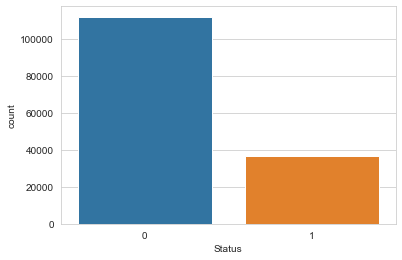

In [207]:
sns.set_style("whitegrid")
sns.countplot(df_train_iv['Status'])

    From the countplot plot of the Status feature, it can be seen that the imbalance of the dataset, where the ratio of the magnitude exceeds 2:1 .

<AxesSubplot:>

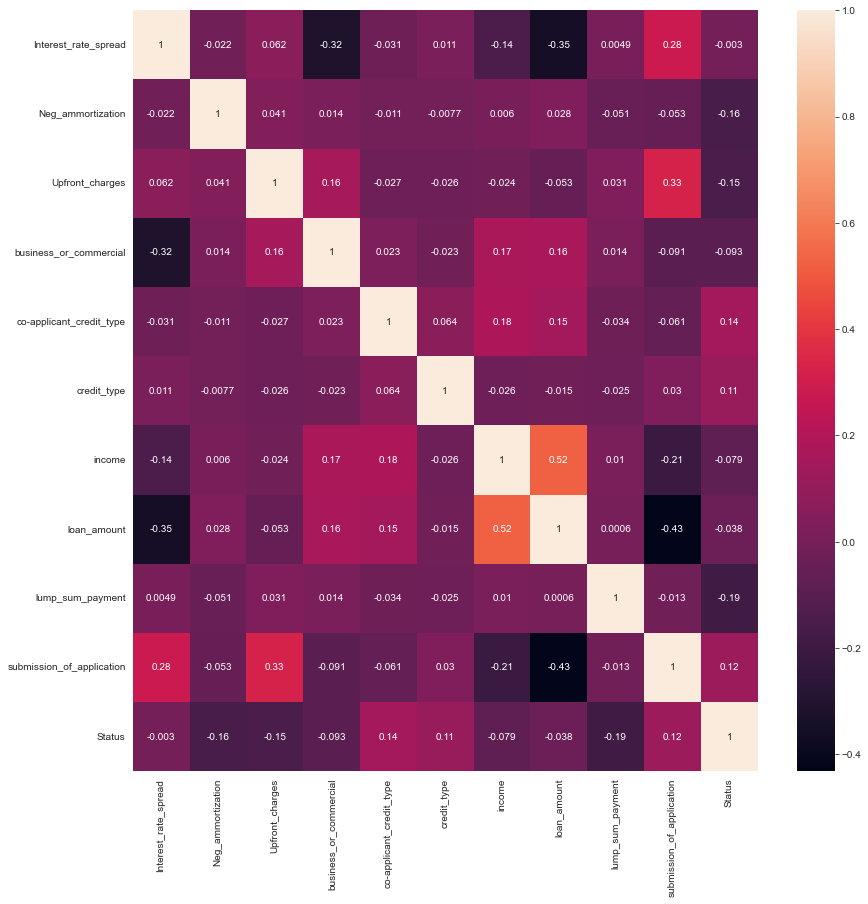

In [208]:
fig = plt.figure(figsize=(14,14))
sns.heatmap(df_train_iv.corr(), annot=True)

Here's how to read the correlation:
- (0 - 1.99) or (-1.99 - 0) , have very weak correlation
- (0.2 - 0.399) or (-3.99 - -1.99), have weak correlation
- (0.4 - 0.599) or (-5.99 - -0.4), have medium correlation
- (0.6 - 0.799) or (-0.799 - -0.6), have strong correlation
- (0.8 - 1) or (-1 - -0.8), have very strong correlation

    In this data, the largest correlation value is 0.52, which is between income and loan_amount

## Modelling

### Train Test Split

In [211]:
X = df_train_iv.drop(columns = 'Status')
y = df_train_iv['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### XGBoost Classifier

#### Train Data

    Try and error will be carried out on changes in model parameters during data training with data validation by reviewing the value of each AUC.

In [215]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 6,
            'reg_alpha': 70,
            'reg_lambda': 33,
            'learning_rate': 0.2,
            'n_estimators': 600,
            'eval_metric':'logloss',
            'min_child_weight': 1,
            'scale_pos_weight': 2,
            'use_label_encoder': False,
            'tree_method': 'hist' 
        }

# Default Hyperparam XGBoost
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=70, reg_lambda=33, scale_pos_weight=2, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [216]:
y_train_pred = xgb_clf.predict(X_train)
y_proba = xgb_clf.predict_proba(X_train)

(0.0, 1.0)

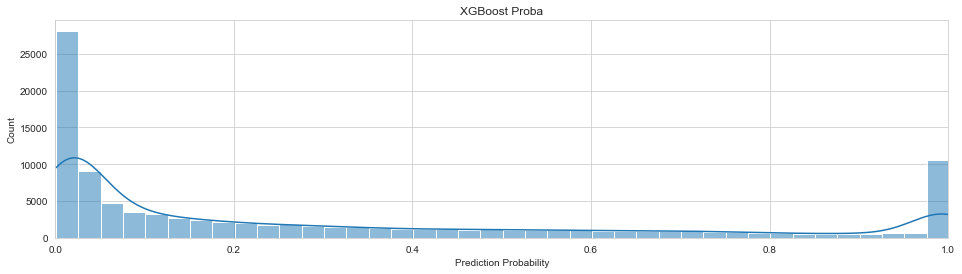

In [217]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.histplot(x=pd.Series(y_proba[:,1]),
             binwidth=0.025,
             kde=True,
             ax=ax)

ax.set_title('XGBoost Proba')
ax.set_xlabel('Prediction Probability')
ax.set_xlim(0,1)

In [218]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_proba[:, -1])
roc_auc_value = roc_auc_score(y_train, y_proba[:, -1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)
roc_auc_value_train = round(roc_auc_value*100, 2)

print('AUC for XGBoost on train data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGboost on train data: ', round(gini_value*100, 2), '%')

AUC for XGBoost on train data:  95.24 %
Gini for XGboost on train data:  90.48 %


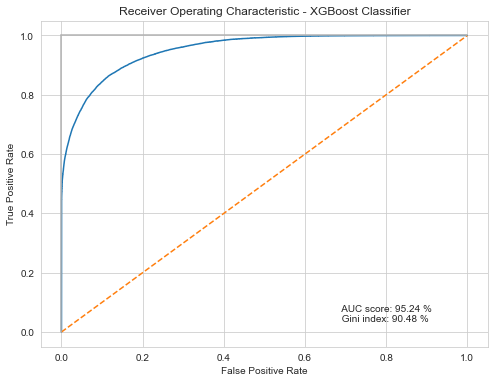

In [220]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - XGBoost Classifier')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.text(ax.get_xlim()[1]*6/10, 
         0, 
         f"""\n
         AUC score: {round(roc_auc_value*100, 2)} %
         Gini index: {round(gini_value*100, 2)} %
         """)

plt.show()

#### Val Data

In [221]:
y_test_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)

(0.0, 1.0)

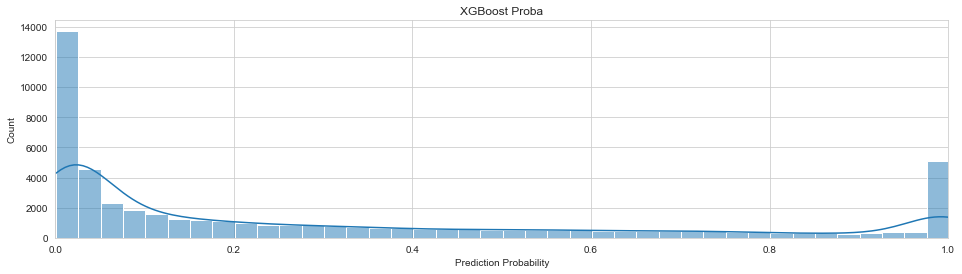

In [222]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.histplot(x=pd.Series(y_proba[:,1]),
             binwidth=0.025,
             kde=True,
             ax=ax)

ax.set_title('XGBoost Proba')
ax.set_xlabel('Prediction Probability')
ax.set_xlim(0,1)

In [223]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_proba[:, -1])
roc_auc_value = roc_auc_score(y_test, y_proba[:, -1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)
roc_auc_value_test = round(roc_auc_value*100, 2)

print('AUC for XGBoost on test data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGboost on test data: ', round(gini_value*100, 2), '%')

AUC for XGBoost on test data:  94.75 %
Gini for XGboost on test data:  89.5 %


In [224]:
roc_auc_value_train-roc_auc_value_test

0.4899999999999949

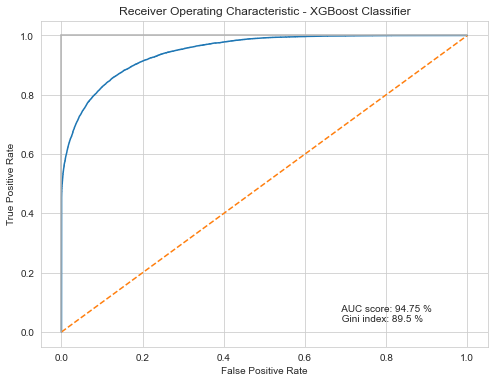

In [225]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - XGBoost Classifier')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.text(ax.get_xlim()[1]*6/10, 
         0, 
         f"""\n
         AUC score: {round(roc_auc_value*100, 2)} %
         Gini index: {round(gini_value*100, 2)} %
         """)

plt.show()

In [226]:
y_predict_prob_1 = y_proba[:, 1]

In [253]:
th = np.arange(0.1,0.91, 0.001).tolist()

In [254]:
th = [round(num, 3) for num in th]

In [257]:
treshold_list = th

column_list = ['threshold', 
             'true_negative', 
             'false_positive',
             'false_negative', 
             'true_positive', 
             'precision', 
             'recall', 'f1-score']

model_result = pd.DataFrame(columns=column_list)

for tresh in treshold_list:    
    y_predict = y_predict_prob_1 > tresh
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    precision = precision_score(y_test, y_predict_prob_1 > tresh).round(4)*100
    recall = recall_score(y_test, y_predict_prob_1 > tresh).round(4)*100
    f1_score =  2 * (recall*precision) / (recall + precision)
    temp_df = pd.DataFrame([tresh, tn, fp, fn, tp, precision, recall, f1_score]).T
    temp_df.columns = column_list
    
    model_result = pd.concat([model_result, temp_df])

model_result

,threshold,true_negative,false_positive,false_negative,true_positive,precision,recall,f1-score
0,0.100,22137.0,14919.0,260.0,11746.0,44.05,97.83,60.747272
0,0.101,22217.0,14839.0,261.0,11745.0,44.18,97.83,60.870775
0,0.102,22267.0,14789.0,268.0,11738.0,44.25,97.77,60.925539
0,0.103,22314.0,14742.0,272.0,11734.0,44.32,97.73,60.984070
0,0.104,22385.0,14671.0,275.0,11731.0,44.43,97.71,61.084217
...,...,...,...,...,...,...,...,...
0,0.905,36989.0,67.0,5989.0,6017.0,98.90,50.12,66.526211
0,0.906,36994.0,62.0,5999.0,6007.0,98.98,50.03,66.464927
0,0.907,36997.0,59.0,6014.0,5992.0,99.02,49.91,66.367934
0,0.908,36999.0,57.0,6021.0,5985.0,99.06,49.85,66.323833


In [259]:
model_result.sort_values(by="f1-score", ascending=False).head()

,threshold,true_negative,false_positive,false_negative,true_positive,precision,recall,f1-score
0,0.559,34696.0,2360.0,2740.0,9266.0,79.70,77.18,78.419760
0,0.561,34712.0,2344.0,2754.0,9252.0,79.79,77.06,78.401242
0,0.557,34664.0,2392.0,2723.0,9283.0,79.51,77.32,78.399709
0,0.558,34676.0,2380.0,2732.0,9274.0,79.58,77.24,78.392542
0,0.560,34701.0,2355.0,2749.0,9257.0,79.72,77.10,78.388114


    Threshold 0.559 have good f1-score (78.419760)

#### Model Interpretation

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


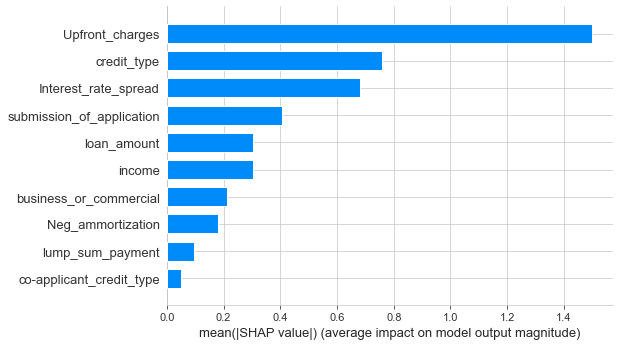

In [231]:
explainer = shap.TreeExplainer(xgb_clf) #(***)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

    Upfront_charges has the biggest impact in this machine learning model.

In [269]:
shap.plots.force(explainer.expected_value,shap_values[0], feature_names=X_test.columns)

    In blue, we have negative form values indicating anything that is pushing Status value in a negative direction. While the red value of the shape represents everything that pushes it in a positive direction.

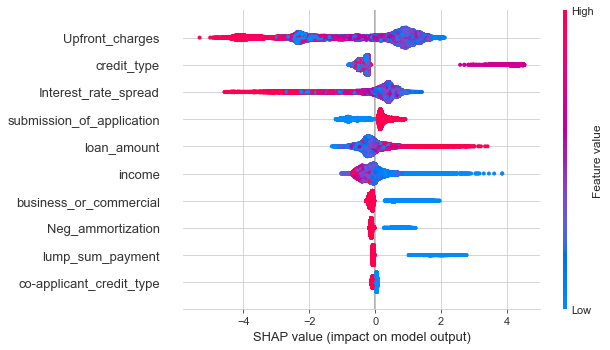

In [274]:
shap.summary_plot(shap_values, X_test)

    This shows the Shap values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis.

    high Interest_rate_spread values are on the left side primarily because they contribute negatively to the status value. Similarly, for income, they have a high impact on pushing the status in the positive direction.